# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

# Profile

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


## Data Cleaning : Profile

In [7]:
#Check for any duplicated entry on profile ID
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile[profile['id'].duplicated()]

,gender,age,id,became_member_on,income


In [8]:
type(profile['became_member_on'][1])

numpy.int64

In [9]:
#Change the "became_member_on" Column data type from int64 to datetime for futher explorations
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [10]:
#add column for date, month and year extracted from became_member_on column
profile['join_year'] = profile['became_member_on'].dt.year
profile['join_month'] = profile['became_member_on'].dt.month
profile['join_day'] = profile['became_member_on'].dt.day
profile.head()

,gender,age,id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4


In [11]:
#rename column id to customer_id for future merging purpose
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [12]:
#brached out dataframe into two:
# df_profile with all the data and profile without any NA values
df_profile=profile

In [13]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [14]:
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
join_year              0
join_month             0
join_day               0
dtype: int64

In [15]:
profile[profile['gender'].isnull()]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [16]:
profile[profile['income'].isnull()]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


In [17]:
#If we look at the NaN values they are  from the same age i.e, 118, let's try to find out if that's the value that NaN corresponds to 

profile[((profile['income'].isnull()) & (profile['gender'].isnull()))]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7,12
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8,4
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017,10,2
...,...,...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016,9,1
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016,4,15
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018,3,5
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016,1,16


So, as per my understanding the company data is putting age 118 where the complete data about a person is unavailable which is basically regarding income and gender. Let's check if we can consider to remove the rows from the column so that we can work on the complete dataset.

In [18]:
# Percentage of data missing

len(profile[profile['age']==118])/len(profile)

0.12794117647058822

Since the percentage of data missing is not high enough to make a considerable impact. We will remove the rows with age 118

In [19]:
profile.drop(profile[profile['age']==118].index, axis=0, inplace=True)

In [20]:
profile[profile['gender'].isnull()==True]

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day


In [21]:
profile['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [22]:
profile[profile['gender']=='O']

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
31,O,53,d1ede868e29245ea91818a903fec04c6,2017-09-16,52000.0,2017,9,16
273,O,60,d0be9ff460964c3398a33ad9b2829f3a,2018-02-16,94000.0,2018,2,16
383,O,49,0d0a9ca9281248a8a35806c9ae68f872,2017-12-07,42000.0,2017,12,7
513,O,63,01f46a5191424005af436cdf48a5da7c,2015-09-20,89000.0,2015,9,20
576,O,73,644ac06dc9b34a5bbd237a465cf47571,2018-03-16,88000.0,2018,3,16
...,...,...,...,...,...,...,...,...
16670,O,76,e8926849bbe24ce488d4f3fcd3b537e8,2018-03-20,52000.0,2018,3,20
16683,O,49,1f68e9b6850f49348235a281a47d9f15,2017-06-07,56000.0,2017,6,7
16731,O,51,a97208c5be42445d9949e82e0f70f622,2016-07-07,55000.0,2016,7,7
16741,O,56,994b6ef7a8ca46e3b379518399f6ec93,2018-02-21,52000.0,2018,2,21


In [23]:
'''df_temp=pd.get_dummies(data=profile.gender, prefix='gender_type')
profile=pd.concat([profile, df_temp], axis=1)
profile.drop('gender', axis=1, inplace=True)'''

"df_temp=pd.get_dummies(data=profile.gender, prefix='gender_type')\nprofile=pd.concat([profile, df_temp], axis=1)\nprofile.drop('gender', axis=1, inplace=True)"

In [24]:
profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,26
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,9
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,11
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,7


In [25]:
profile.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
join_year           0
join_month          0
join_day            0
dtype: int64

In [26]:
profile

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,26
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,9
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,11
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3,7


# Portfolio

In [27]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Data Cleaning : Portfolio

In [28]:
# Rename portfolio id column to offer_id column to remove confusion between different id column in other dataframes
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [29]:
# One-Hot encoding of offer type column
df_temp=pd.get_dummies(data=portfolio.offer_type, prefix='offer_type')
df_portfolio=pd.concat([portfolio, df_temp], axis=1)
df_portfolio.drop('offer_type', axis=1, inplace=True)


In [30]:
# Converting Channels variable into respective columns
unq_channels=list(set(itertools.chain(*portfolio['channels'].tolist())))
for channel in unq_channels:
    df_portfolio[channel] = df_portfolio.channels.apply(lambda x:1 if channel in x else 0 )
df_portfolio.drop('channels', axis=1, inplace=True)    


In [31]:
df_portfolio

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,web,mobile,social,email
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,1,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,1,1,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


In [32]:
df_portfolio.sum()

reward                                                                     42
difficulty                                                                 77
duration                                                                   65
offer_id                    ae264e3637204a6fb9bb56bc8210ddfd4d5c57ea9a6940...
offer_type_bogo                                                             4
offer_type_discount                                                         4
offer_type_informational                                                    2
web                                                                         8
mobile                                                                      9
social                                                                      6
email                                                                      10
dtype: object

# Transcript

In [33]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Data Cleaning : Transcript

In [34]:
#rename column id to customer_id for future merging purpose
transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [35]:
#Change and rouding off the time in hours into days for better understanding 
transcript['days'] = transcript.time.apply(lambda x: round(x/24.0))
#transcript.rename(columns={'time':'days'}, inplace=True)
transcript


,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [36]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [37]:
transcript[transcript['event']=='transaction']

,customer_id,event,value,time,days
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,30
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,30
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,30
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,30


In [38]:
transcript[transcript['event']=='offer received']

,customer_id,event,value,time,days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,24
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,24
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,24


In [39]:
#Transaction has amount variable under value, and offer received, offer viewed and offer completed has offer id
#Extract the variables from value column 
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', np.nan))
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id', x.get('offer_id',np.nan)))
transcript.drop('value',inplace=True, axis=1)

In [40]:
transcript

,customer_id,event,time,days,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


In [41]:
transcript_offer=transcript[transcript['amount'].isnull()]
transcript_offer.drop('amount', axis=1, inplace=True)
transcript_offer['event'].unique()



C:\ana\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [42]:
transcript_offer

,customer_id,event,time,days,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,30,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,30,0b1e1539f2cc45b7b9fa7c272da2e1d7
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,30,fafdcd668e3743c1bb461111dcafc2a4


In [43]:
transcript_trans=transcript[transcript['amount'].notnull()]
transcript_trans

,customer_id,event,time,days,amount,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,0,18.97,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,30,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,30,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,30,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,30,3.53,NaN


In [44]:
offer_reference = {}

for i,j in zip(portfolio['offer_id'], portfolio['offer_type']):
    offer_reference[i] = j
    

offer_duration_reference = {}

for i,j in zip(portfolio['offer_id'], portfolio['duration']):
    offer_duration_reference[i] = j*24
    
    
full_data = []

# Iterate through each person

for person in list(transcript['customer_id'].unique()):
    
    not_completed = {}
    received = []
    active = []
    total_data = {}
    information = []

    for index, row in transcript[transcript['customer_id'] == person].iterrows():

        if row['event'] == 'offer received':

            # Everytime there is an offer received, do this
            received.append(row['offer_id'])
            key = row['offer_id'] + '-' + str(received.count(row['offer_id']))
            not_completed[key] = row['time']
            total_data[key] = [row['customer_id'], row['offer_id'], 0, 0, 0, 0] 


        if row['event'] == 'offer viewed':

            # If the customers have seen the informational offer
            if offer_reference[row['offer_id']] == 'informational':
                information.append(row['offer_id'])

            # Everytime the offer is viewed, do this
            active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

            # If there is only one offer_id active
            if len(active) == 1:

                # Only change the value if the offer is not completed yet
                if active[0] in not_completed:                    
                    total_data[active[0]][2] = 1

            # If there are more than one offer_id active
            else:
                for offer_id in active:
                    if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                        if total_data[offer_id][2] == 1:
                            continue
                        total_data[offer_id][2] = 1
                        break


        if row['event'] == 'offer completed':

            # If the users completed the offer and have seen the informational offer
            info = False
            if len(information) > 0:
                info = True

            # Everytime the offer is completed, do this
            active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

            # If there is only one offer_id active
            if len(active) == 1:
                total_data[active[0]][3] = 1
                total_data[active[0]][5] = row['time'] - not_completed[active[0]]
                not_completed.pop(active[0])

                if info:
                    total_data[active[0]][4] = 1

                continue

            # If there is more that one offer_id active
            else:
                for offer_id in active:
                    if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                        total_data[offer_id][3] = 1
                        total_data[offer_id][5] = row['time'] - not_completed[offer_id]
                        not_completed.pop(offer_id)

                        if info:
                            total_data[offer_id][4] = 1

                        break

    for index, value in total_data.items():
        full_data += [value]

In [45]:
received

[]

In [46]:
compiled_data['offer_id']

NameError: name 'compiled_data' is not defined

In [47]:
# Create a dataframe based on the compile result
compiled_data = pd.DataFrame(full_data, columns=['customer_id', 'offer_id', 'viewed', 'completed', 'view_information', 'time_completed'])

compiled_data.head()

,customer_id,offer_id,viewed,completed,view_information,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0


In [48]:
df_transcript_offer

NameError: name 'df_transcript_offer' is not defined

In [49]:
compiled_data_merged = compiled_data.merge(df_portfolio, left_on='offer_id', right_on='offer_id')
check_data = compiled_data_merged.merge(df_profile, left_on='customer_id', right_on='customer_id')
check_data

,customer_id,offer_id,viewed,completed,view_information,time_completed,reward,difficulty,duration,offer_type_bogo,...,mobile,social,email,gender,age,became_member_on,income,join_year,join_month,join_day
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,5,7,1,...,1,0,1,F,75,2017-05-09,100000.0,2017,5,9
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,0,3,0,...,1,1,1,F,75,2017-05-09,100000.0,2017,5,9
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,10,7,1,...,1,1,1,F,75,2017-05-09,100000.0,2017,5,9
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6,5,5,5,1,...,1,1,1,F,75,2017-05-09,100000.0,2017,5,9
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,114,5,5,7,1,...,1,0,1,M,68,2018-04-26,70000.0,2018,4,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,54,3,7,7,0,...,1,1,1,F,68,2017-06-02,51000.0,2017,6,2
66497,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,36,3,7,7,0,...,1,1,1,F,68,2017-06-02,51000.0,2017,6,2
66498,9a3f45cf29ef428b932492c7a5d6ac52,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,102,3,7,7,0,...,1,1,1,M,20,2016-10-19,70000.0,2016,10,19
66499,ef1e309b68ce4278bf7d80b764bc46d6,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,42,3,7,7,0,...,1,1,1,M,45,2015-09-09,62000.0,2015,9,9


In [50]:
check_data.to_csv(r'C:\\Users\\Suramya Pathak\\Untitled Folder\\Projects\\Untitled Folder\\SB\\check_data.csv',header=False, index=False, sep='|')

In [51]:
check_data.columns

Index(['customer_id', 'offer_id', 'viewed', 'completed', 'view_information',
       'time_completed', 'reward', 'difficulty', 'duration', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'mobile',
       'social', 'email', 'gender', 'age', 'became_member_on', 'income',
       'join_year', 'join_month', 'join_day'],
      dtype='object')

In [52]:
re_check_data=check_data.drop(['became_member_on','join_year', 'join_month', 'join_day'],axis=1)

In [53]:
re_check_data

,customer_id,offer_id,viewed,completed,view_information,time_completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,mobile,social,email,gender,age,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,5,7,1,0,0,1,1,0,1,F,75,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,0,3,0,0,1,0,1,1,1,F,75,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,10,7,1,0,0,0,1,1,1,F,75,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6,5,5,5,1,0,0,1,1,1,1,F,75,100000.0
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,114,5,5,7,1,0,0,1,1,0,1,M,68,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,54,3,7,7,0,1,0,1,1,1,1,F,68,51000.0
66497,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,36,3,7,7,0,1,0,1,1,1,1,F,68,51000.0
66498,9a3f45cf29ef428b932492c7a5d6ac52,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,102,3,7,7,0,1,0,1,1,1,1,M,20,70000.0
66499,ef1e309b68ce4278bf7d80b764bc46d6,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,42,3,7,7,0,1,0,1,1,1,1,M,45,62000.0


In [54]:

new_df=re_check_data

In [94]:
comp_df1

,0
web,19988
social,17192
email,22579
mobile,21266


In [95]:
mcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (re_check_data['completed']==1)& (re_check_data['gender']=='M')][['web','social','email','mobile']].sum())

In [96]:
mcomp_df1

,0
web,10426
social,8867
email,11670
mobile,11004


<AxesSubplot:>

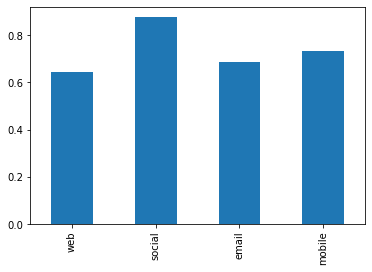

In [190]:
mcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1)& (new_df['gender']=='M')][['web','social','email','mobile']].sum())


mnview_df1=pd.DataFrame(new_df[(new_df['viewed']==0) & (new_df['completed']==1)& (new_df['gender']=='M')][['web','social','email','mobile']].sum())


msent_df1=pd.DataFrame(new_df[new_df['gender']=='M'][['web','social','email','mobile']].sum())



mview_df1=pd.DataFrame(new_df[(new_df['viewed']==1)& (new_df['gender']=='M')][['web','social','email','mobile']].sum())


mvis_df=pd.concat([msent_df1, mview_df1, mcomp_df1], axis=1)

mvis_df.columns=['Sent','Viewed','Completed']
mvis_df

mvs_ratio=mvis_df['Viewed']/mvis_df['Sent']
mvs_ratio.plot.bar()

In [195]:
mvs_ratio.sort_values()

web       0.645968
email     0.687849
mobile    0.733697
social    0.877554
dtype: float64

In [197]:
mcv_ratio.sort_values()

mobile    0.437222
social    0.442024
email     0.444961
web       0.528595
dtype: float64

<AxesSubplot:>

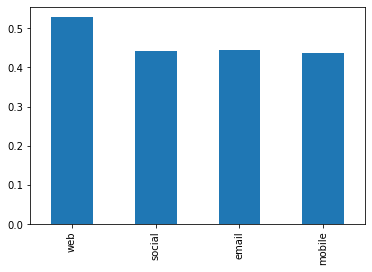

In [192]:
mcv_ratio=mvis_df['Completed']/mvis_df['Viewed']
mcv_ratio.plot.bar()

web       0.528595
social    0.442024
email     0.444961
mobile    0.437222
dtype: float64

In [161]:
new_df.gender.value_counts()

M    38129
F    27456
O      916
Name: gender, dtype: int64

In [162]:
new_df[(new_df['gender']=='F') & (new_df['gender']=='M')]

,customer_id,offer_id,viewed,completed,view_information,time_completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,mobile,social,email,gender,age,income,age_group


In [163]:
new_df[(new_df['gender']=='F') & (new_df['completed']==1)&(new_df['viewed']==1)]['customer_id'].count()

10518

In [164]:
new_df[(new_df['gender']=='M') & (new_df['completed']==1)&(new_df['viewed']==1)]['customer_id'].count()

11670

<AxesSubplot:>

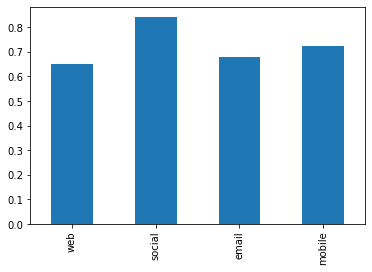

In [198]:
fcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1) & (new_df['gender']=='F')][['web','social','email','mobile']].sum())


fnview_df1=pd.DataFrame(new_df[(new_df['viewed']==0) & (new_df['completed']==1) & (new_df['gender']=='F')][['web','social','email','mobile']].sum())


fsent_df1=pd.DataFrame(new_df[new_df['gender']=='F'][['web','social','email','mobile']].sum())



fview_df1=pd.DataFrame(new_df[(new_df['viewed']==1)& (new_df['gender']=='F')][['web','social','email','mobile']].sum())


fvis_df=pd.concat([fsent_df1, fview_df1, fcomp_df1], axis=1)

fvis_df.columns=['Sent','Viewed','Completed']
fvis_df

fvs_ratio=fvis_df['Viewed']/fvis_df['Sent']
fvs_ratio.plot.bar()

In [203]:
fvs_ratio.sort_values()

web       0.650956
email     0.680398
mobile    0.722409
social    0.841326
dtype: float64

In [204]:
fcv_ratio.sort_values()

mobile    0.556229
email     0.563032
social    0.583907
web       0.645826
dtype: float64

<AxesSubplot:>

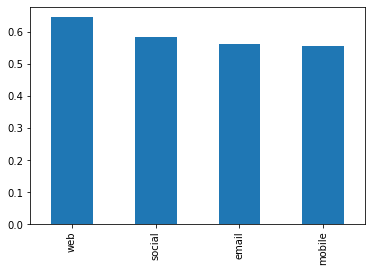

In [200]:
fcv_ratio=fvis_df['Completed']/fvis_df['Viewed']
fcv_ratio.plot.bar()

In [207]:
new_df

,customer_id,offer_id,viewed,completed,view_information,time_completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,mobile,social,email,gender,age,income,age_group
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,5,7,1,0,0,1,1,0,1,F,75,100000.0,"(68, 78]"
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,0,3,0,0,1,0,1,1,1,F,75,100000.0,"(68, 78]"
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,10,7,1,0,0,0,1,1,1,F,75,100000.0,"(68, 78]"
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6,5,5,5,1,0,0,1,1,1,1,F,75,100000.0,"(68, 78]"
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,114,5,5,7,1,0,0,1,1,0,1,M,68,70000.0,"(58, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,54,3,7,7,0,1,0,1,1,1,1,F,68,51000.0,"(58, 68]"
66497,c28c139d78c94303a0a993e3731e789f,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,36,3,7,7,0,1,0,1,1,1,1,F,68,51000.0,"(58, 68]"
66498,9a3f45cf29ef428b932492c7a5d6ac52,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,102,3,7,7,0,1,0,1,1,1,1,M,20,70000.0,"(18, 28]"
66499,ef1e309b68ce4278bf7d80b764bc46d6,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,42,3,7,7,0,1,0,1,1,1,1,M,45,62000.0,"(38, 48]"


In [246]:
omcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1) & (new_df['gender']=='M')])['offer_id'].value_counts()
omcomp_df1

fafdcd668e3743c1bb461111dcafc2a4    2388
2298d6c36e964ae4a3e7e9706d1fb8c2    2251
f19421c1d4aa40978ebb69ca19b0e20d    1747
ae264e3637204a6fb9bb56bc8210ddfd    1244
4d5c57ea9a6940dd891ad53e9dbe8da0    1237
2906b810c7d4411798c6938adc9daaa5    1086
9b98b8c7a33c4b65b9aebfe6a799e6d9    1051
0b1e1539f2cc45b7b9fa7c272da2e1d7     666
Name: offer_id, dtype: int64

In [212]:
ofcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1) & (new_df['gender']=='F')])['offer_id'].value_counts()
ofcomp_df1                                                                                                      

fafdcd668e3743c1bb461111dcafc2a4    1913
2298d6c36e964ae4a3e7e9706d1fb8c2    1820
f19421c1d4aa40978ebb69ca19b0e20d    1562
4d5c57ea9a6940dd891ad53e9dbe8da0    1463
ae264e3637204a6fb9bb56bc8210ddfd    1304
9b98b8c7a33c4b65b9aebfe6a799e6d9     932
2906b810c7d4411798c6938adc9daaa5     913
0b1e1539f2cc45b7b9fa7c272da2e1d7     611
Name: offer_id, dtype: int64

In [214]:
omcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1) & (new_df['gender']=='O')])['offer_id'].value_counts()
omcomp_df1                                                                                                      

fafdcd668e3743c1bb461111dcafc2a4    61
f19421c1d4aa40978ebb69ca19b0e20d    60
2298d6c36e964ae4a3e7e9706d1fb8c2    59
9b98b8c7a33c4b65b9aebfe6a799e6d9    48
2906b810c7d4411798c6938adc9daaa5    44
ae264e3637204a6fb9bb56bc8210ddfd    43
4d5c57ea9a6940dd891ad53e9dbe8da0    40
0b1e1539f2cc45b7b9fa7c272da2e1d7    36
Name: offer_id, dtype: int64

In [218]:
new_df[(new_df['offer_id']=='2906b810c7d4411798c6938adc9daaa5')]

,customer_id,offer_id,viewed,completed,view_information,time_completed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,web,mobile,social,email,gender,age,income,age_group
6,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,2,10,7,0,1,0,1,1,0,1,M,68,70000.0,"(58, 68]"
12,389bc3fa690240e798340f5a15918d5c,2906b810c7d4411798c6938adc9daaa5,1,1,0,162,2,10,7,0,1,0,1,1,0,1,M,65,53000.0,"(58, 68]"
18,d058f73bf8674a26a95227db098147b1,2906b810c7d4411798c6938adc9daaa5,1,1,0,24,2,10,7,0,1,0,1,1,0,1,F,56,88000.0,"(48, 58]"
24,ebe7ef46ea6f4963a7dd49f501b26779,2906b810c7d4411798c6938adc9daaa5,1,1,1,24,2,10,7,0,1,0,1,1,0,1,M,59,41000.0,"(58, 68]"
29,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,0,1,0,132,2,10,7,0,1,0,1,1,0,1,F,96,89000.0,"(88, 98]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66016,1044403864ed41af9cc17577c185abc4,2906b810c7d4411798c6938adc9daaa5,1,1,0,78,2,10,7,0,1,0,1,1,0,1,M,33,39000.0,"(28, 38]"
66019,e63e42480aae4ede9f07cac49c8c3f78,2906b810c7d4411798c6938adc9daaa5,0,0,0,0,2,10,7,0,1,0,1,1,0,1,F,70,79000.0,"(68, 78]"
66020,e63e42480aae4ede9f07cac49c8c3f78,2906b810c7d4411798c6938adc9daaa5,0,0,0,0,2,10,7,0,1,0,1,1,0,1,F,70,79000.0,"(68, 78]"
66021,fccc9279ba56411f80ffe8ce7e0935cd,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,2,10,7,0,1,0,1,1,0,1,F,81,94000.0,"(78, 88]"


In [62]:
comp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (re_check_data['completed']==1)][['web','social','email','mobile']].sum())
comp_df=comp_df1

nview_df1=pd.DataFrame(new_df[(new_df['viewed']==0) & (re_check_data['completed']==1)][['web','social','email','mobile']].sum())
nview_df=nview_df1




In [63]:
sent_df1=pd.DataFrame(new_df[['web','social','email','mobile']].sum())
sent_df=sent_df1


In [64]:
view_df1=pd.DataFrame(new_df[(new_df['viewed']==1)][['web','social','email','mobile']].sum())
view_df=view_df1


In [184]:
vis_df=pd.concat([sent_df1, view_df1, comp_df1], axis=1)

vis_df.columns=['Sent','Viewed','Completed']
vis_df

,Sent,Viewed,Completed
web,53175,34542,19988
social,39802,34341,17192
email,66501,45621,22579
mobile,59775,43643,21266


<AxesSubplot:>

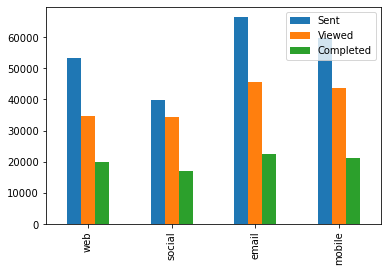

In [189]:
vis_df.plot.bar()

<AxesSubplot:>

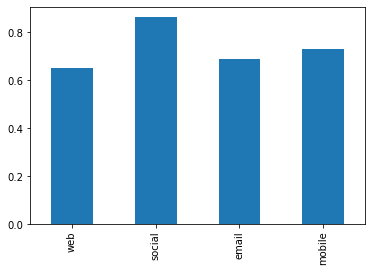

In [185]:
vs_ratio=vis_df['Viewed']/vis_df['Sent']
vs_ratio.plot.bar()

In [186]:
vs_ratio.sort_values()

web       0.649591
email     0.686020
mobile    0.730121
social    0.862796
dtype: float64

In [187]:
vc_ratio.sort_values()

mobile    0.487272
email     0.494926
social    0.500626
web       0.578658
dtype: float64

In [ ]:
vcs_ratio.plot.bar()

<AxesSubplot:>

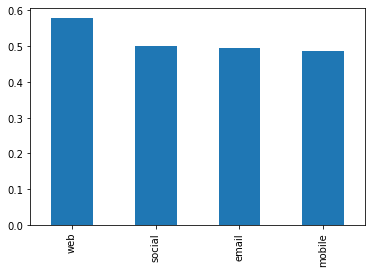

In [178]:
vc_ratio=vis_df['Completed']/vis_df['Viewed']
vc_ratio.plot.bar()

In [175]:
vs_ratio

web       0.649591
social    0.862796
email     0.686020
mobile    0.730121
dtype: float64

<AxesSubplot:xlabel='age_group'>

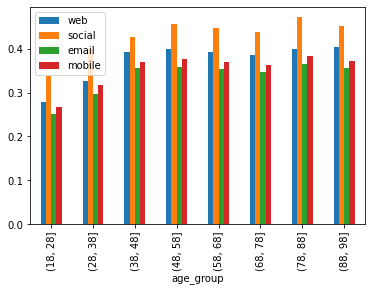

In [68]:
age_diff=np.arange(new_df['age'].min(), new_df['age'].max(), 10)
dash=pd.cut(new_df['age'], age_diff)
new_df['age_group']=dash
new_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (re_check_data['completed']==1)])
new_sent=new_df.groupby('age_group')[['web','social','email','mobile']].sum()
new_completed=new_df1.groupby('age_group')[['web','social','email','mobile']].sum()
new_age=new_completed/new_sent
new_age.plot.bar()

In [69]:
new_age
data_cum


NameError: name 'data_cum' is not defined

In [70]:
data

NameError: name 'data' is not defined

In [ ]:
category_names=['web','social','email','mobile']
labels = list(dash.unique())
data = np.array(list(new_age.loc[:,:].values))
row_sums = data.sum(axis=1)
new_matrix = data / row_sums[:, np.newaxis]
data_cum = new_matrix.cumsum(axis=1)
category_colors = plt.get_cmap('Blues')(
np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(11, 8))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())
plt.title('Top 10 counties : Job Satisfaction')

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.5,label=colname, color=color)
    xcenters = starts + widths / 2
        
    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.1 else 'black'
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        ax.text(x, y, str(float(c)), ha='center', va='center',
                color=text_color)
        ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='small')


<AxesSubplot:xlabel='offer_id'>

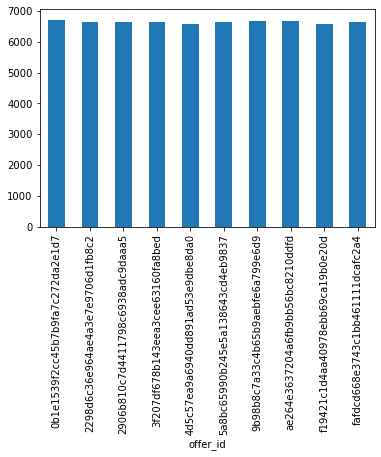

In [239]:
off_sort=new_df.groupby('offer_id')['customer_id'].count()
off_sort.plot.bar()

In [245]:
new_df[(new_df['viewed']==1) & (re_check_data['completed']==1)]['offer_id'].count()

22579

In [248]:
off_sort

,customer_id
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726
2298d6c36e964ae4a3e7e9706d1fb8c2,6655
2906b810c7d4411798c6938adc9daaa5,6631
3f207df678b143eea3cee63160fa8bed,6657
4d5c57ea9a6940dd891ad53e9dbe8da0,6593
5a8bc65990b245e5a138643cd4eb9837,6643
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685
ae264e3637204a6fb9bb56bc8210ddfd,6683
f19421c1d4aa40978ebb69ca19b0e20d,6576


In [241]:
off_sort=pd.DataFrame(off_sort, index=None)

off_sort

,customer_id
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726
2298d6c36e964ae4a3e7e9706d1fb8c2,6655
2906b810c7d4411798c6938adc9daaa5,6631
3f207df678b143eea3cee63160fa8bed,6657
4d5c57ea9a6940dd891ad53e9dbe8da0,6593
5a8bc65990b245e5a138643cd4eb9837,6643
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685
ae264e3637204a6fb9bb56bc8210ddfd,6683
f19421c1d4aa40978ebb69ca19b0e20d,6576


In [242]:
off_sort.merge(portfolio, right_on='offer_id', left_on='offer_id')

,offer_id,customer_id,reward,channels,difficulty,duration,offer_type
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,5,"[web, email]",20,10,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,3,"[web, email, mobile, social]",7,7,discount
2,2906b810c7d4411798c6938adc9daaa5,6631,2,"[web, email, mobile]",10,7,discount
3,3f207df678b143eea3cee63160fa8bed,6657,0,"[web, email, mobile]",0,4,informational
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,10,"[web, email, mobile, social]",10,5,bogo
5,5a8bc65990b245e5a138643cd4eb9837,6643,0,"[email, mobile, social]",0,3,informational
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,5,"[web, email, mobile]",5,7,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,10,"[email, mobile, social]",10,7,bogo
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,5,"[web, email, mobile, social]",5,5,bogo
9,fafdcd668e3743c1bb461111dcafc2a4,6652,2,"[web, email, mobile, social]",10,10,discount


In [72]:

trans_pro=profile.merge(transcript_trans, left_on='customer_id', right_on='customer_id')
trans_pro

,gender,age,customer_id,became_member_on,income,join_year,join_month,join_day,event,time,days,amount,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,18,1,21.51,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,144,6,32.28,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,transaction,528,22,23.22,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,132,6,19.89,NaN
4,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,transaction,144,6,17.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123952,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,84,4,25.19,NaN
123953,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,96,4,21.53,NaN
123954,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,480,20,30.57,NaN
123955,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,7,22,transaction,486,20,19.47,NaN


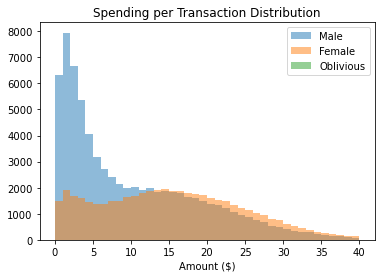

In [73]:
plt.hist(trans_pro[trans_pro['gender'] == 'M']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Male')
plt.hist(trans_pro[trans_pro['gender'] == 'F']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Female')
plt.hist(trans_pro[trans_pro['gender'] == '0']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Oblivious')
plt.legend(loc='upper right')

plt.title('Spending per Transaction Distribution')
plt.xlabel('Amount ($)')
plt.show()

In [220]:
trans_pro[trans_pro['gender']=='M']['amount'].mean()

11.606600269252954

For male the buying frquency is high however, the amount of purchase is lower than female, so to increase the amount, we need t find the mean value of all the purchases made by male population and then create offers around that amount
This would be the mean value of amount that is paid by male, we need to build more packages around it. That would increase the sale volume


In [222]:
ofcomp_df1=pd.DataFrame(new_df[(new_df['viewed']==1) & (new_df['completed']==1) & (new_df['gender']=='F')])['offer_id'].value_counts()
ofcomp_df1 

fafdcd668e3743c1bb461111dcafc2a4    1913
2298d6c36e964ae4a3e7e9706d1fb8c2    1820
f19421c1d4aa40978ebb69ca19b0e20d    1562
4d5c57ea9a6940dd891ad53e9dbe8da0    1463
ae264e3637204a6fb9bb56bc8210ddfd    1304
9b98b8c7a33c4b65b9aebfe6a799e6d9     932
2906b810c7d4411798c6938adc9daaa5     913
0b1e1539f2cc45b7b9fa7c272da2e1d7     611
Name: offer_id, dtype: int64

In [223]:
portfolio[(portfolio['offer_id']=='fafdcd668e3743c1bb461111dcafc2a4')]

,reward,channels,difficulty,duration,offer_type,offer_id
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4


In [224]:
portfolio[(portfolio['offer_id']=='2298d6c36e964ae4a3e7e9706d1fb8c2')]

,reward,channels,difficulty,duration,offer_type,offer_id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2


For female customers we need to increase the frequency as the average speding amount is more than male
We need to create offer with lower validity (duration) and lower difficulties similar to two top viewed as well as complted offers. this will increase the frequency

In [74]:
trans_pro[['gender','amount']]


,gender,amount
0,F,21.51
1,F,32.28
2,F,23.22
3,F,19.89
4,F,17.78
...,...,...
123952,F,25.19
123953,F,21.53
123954,F,30.57
123955,F,19.47


In [75]:
gen_pro=trans_pro[['gender','amount']]

In [76]:

gen_pro=gen_pro.groupby('gender')['amount'].mean()

In [77]:
gen_pro

gender
F    17.490077
M    11.606600
O    14.798731
Name: amount, dtype: float64

<AxesSubplot:xlabel='gender'>

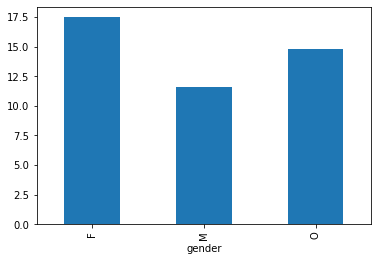

In [78]:
gen_pro.plot.bar()

<AxesSubplot:>

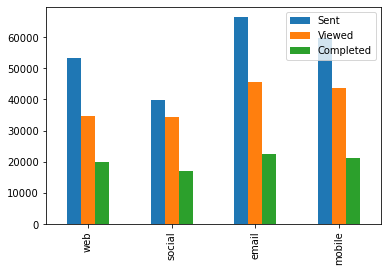

In [79]:
vis_df.plot.bar()

<AxesSubplot:>

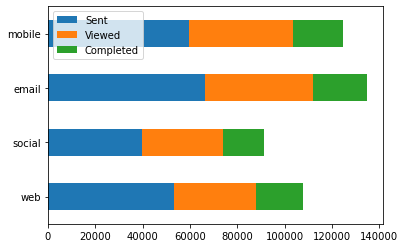

In [80]:
vis_df.plot.barh(stacked=True)

In [81]:
chan_check['web'].sum()/re_check_data['web'].sum()


NameError: name 'chan_check' is not defined

In [82]:
chan_check['social'].sum()/re_check_data['social'].sum()

NameError: name 'chan_check' is not defined

In [83]:
re_check_data['social'].sum()/re_check_data['web'].sum()

0.7485096379877763

In [84]:
chan_check['email'].sum()/re_check_data['email'].sum()

NameError: name 'chan_check' is not defined

In [85]:
re_check_data['email'].sum()

66501

In [86]:
chan_check['mobile'].sum()/re_check_data['mobile'].sum()

NameError: name 'chan_check' is not defined

In [87]:
view_check=re_check_data[(re_check_data['viewed']==1)]

In [88]:
view_check['social'].sum()/re_check_data['social'].sum()

0.862795839405055

In [89]:
view_check['email'].sum()/re_check_data['email'].sum()

0.6860197591013669

In [90]:
view_check['mobile'].sum()/re_check_data['mobile'].sum()

0.7301212881639482

In [91]:
view_check['web'].sum()/re_check_data['web'].sum()


0.6495909732016926

In [92]:

chan_visual

NameError: name 'chan_visual' is not defined

In [93]:
chan_visual.plot.bar()

NameError: name 'chan_visual' is not defined

In [ ]:
compiled_data_merged = compiled_data.merge(portfolio, left_on='offer_id', right_on='offer_id')
complete_data = compiled_data_merged.merge(df_profile, left_on='customer_id', right_on='customer_id').drop(columns=['customer_id'])

complete_data.head()

In [ ]:
len(complete_data)

Splitting transcript database into two different databases transcript_offer for offer based information and transcript_trans for transaction based information

In [ ]:
transcript_offer=transcript[transcript['amount'].isnull()]
transcript_offer

In [ ]:
transcript_offer.drop('amount', axis=1, inplace=True)

In [ ]:
transcript_offer['event'].unique()

In [ ]:
df_temp=pd.get_dummies(transcript_offer.event)
df_transcript_offer=pd.concat([transcript_offer, df_temp], axis=1)
df_transcript_offer.drop('event', axis=1, inplace=True)

In [ ]:
df_transcript_offer

In [ ]:
transcript_trans=transcript[transcript['amount'].notnull()]

In [ ]:
transcript_trans

In [ ]:
transcript_trans['event'].unique()

In [ ]:
transcript_trans.drop('offer_id', axis=1, inplace=True)

In [ ]:
transcript_trans

# Explore Data

## Age Group Distribution

In [ ]:
profile['age'].describe()

In [ ]:
age_diff=np.arange(profile['age'].min(), profile['age'].max(), 10)
dash=pd.cut(profile['age'], age_diff)
age_visual=profile.groupby(dash)['customer_id'].count()
age_visual

In [ ]:
ax=sns.barplot(age_visual.index, age_visual.values, palette='colorblind')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
income_gr = profile.groupby(pd.cut(profile['income'], np.arange(profile['income'].min(), profile['income'].max(), 10000)))['customer_id'].count()
income_gr

In [ ]:
ax=sns.barplot(income_gr.index, income_gr.values, palette='colorblind')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
x_axis=(profile[profile['gender_type_F']==1]['gender_type_F'].count(),
profile[profile['gender_type_M']==1]['gender_type_M'].count(),
profile[profile['gender_type_O']==1]['gender_type_O'].count())

In [ ]:
ax=sns.barplot(x_axis, x_axis, palette='colorblind')
labels= ['Gender O','Gender F' ,'Gender M']
ax.set_xticklabels(labels=labels, rotation=90);

In [ ]:
##Member Joining Date
mem_yr_mo_gr=profile.groupby(profile['became_member_on'].dt.to_period('M'))['customer_id'].count()#membership joined on month year basis
mem_qua = profile.groupby(profile['became_member_on'].dt.to_period('Q'))['customer_id'].count() #membership joined on quaterly basis

In [ ]:
event_gr=transcript.groupby(['event'])['customer_id'].count() # grouping on the basis of event

In [ ]:

transcript_df=df_transcript_offer.merge(transcript_trans, on ='customer_id', how='left')

In [ ]:
len(transcript_df)

In [ ]:
transcript_df=transcript_df.drop_duplicates(keep='first')

In [ ]:
transcript_trans

In [ ]:
complete_data

In [ ]:
complete_data[(complete_data['viewed'] == 0) & (complete_data['completed'] == 1)]['reward'].sum()

In [ ]:
complete_group=complete_data.groupby(['offer_id','offer_type']).count()

In [ ]:
for offer in range(complete_data):
    if offer['completed']==1:
        round(((*total_completed_without_view) / (total_completed))*100, 2)


In [ ]:
complete_data[complete_data['viewed']==0].groupby(['offer_id','offer_type']).sum()

In [ ]:
complete_data

In [ ]:
complete_data.head()

In [ ]:
complete_data[complete_data['offer_type']=='informational']

In [ ]:
indexnames=complete_data[complete_data['offer_type']=='informational'].index
complete_data.drop(indexnames, axis=0, inplace=True)

In [ ]:

df_temp=pd.get_dummies(data=complete_data.gender, prefix='gender_type')
complete_data=pd.concat([complete_data, df_temp], axis=1)
complete_data.drop('gender', axis=1, inplace=True)

df_temp=pd.get_dummies(data=complete_data.offer_type, prefix='offer_type')
complete_data=pd.concat([complete_data, df_temp], axis=1)
complete_data.drop('offer_type', axis=1, inplace=True)

unq_channels=list(set(itertools.chain(*complete_data['channels'].tolist())))
for channel in unq_channels:
    complete_data[channel] = complete_data.channels.apply(lambda x:1 if channel in x else 0 )
complete_data.drop('channels', axis=1, inplace=True) 

In [ ]:
complete_data

In [ ]:
complete_data.drop(['offer_id','became_member_on','join_year','join_month','join_day'], axis=1, inplace=True )

In [ ]:
y=complete_data.iloc[:,:3]

In [ ]:
X=complete_data.iloc[:,3:]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(16,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=3,activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=5,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

In [ ]:
import pandas as pd
check_data=pd.read_csv('check_data.csv', sep='|')

# Findings

## 1. The offers which are not on social media are least popular among the population

In [ ]:
2.